In [1]:
#Author: Michael Elgin (melgin@uwyo.edu)
#2023_10_31

#Notebook for Hyperparameter Optimization

In [2]:
#Modules

#Python 3.11.2
import numpy as np #1.26.0
import pandas as pd #1.5.3
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt #3.7.0

In [3]:
#All regression algorithms will use the white wine dataset.
#Classification will use both colors.
df_red = pd.read_csv("data/winequality-red.csv", sep=";")
df_white = pd.read_csv("data/winequality-white.csv", sep=";")

features_red = df_red.iloc[:, :-1]
features_white = df_white.iloc[:, :-1]
target_red = df_red['quality']
target_white = df_white['quality']

df_red["quality"] = 0
df_white["quality"] = 1
df_all = pd.concat([df_white, df_red], ignore_index=True)
features_all = df_all.iloc[:, :-1]
target_all = df_all['quality']

In [4]:
#Check to ensure target changing process has been done correctly
target_white.describe() #Should have values above 0 and 1

count    4898.000000
mean        5.877909
std         0.885639
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64

In [5]:
target_all.describe() #Should have values as 0 and 1 only

count    6497.000000
mean        0.753886
std         0.430779
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: quality, dtype: float64

In [6]:
#Function to create graphs of average hyperparameter performance and also display best config

def evaluate(best_params,
            hyperparam_data,
            performances,
            model_type,
            is_regression,
            ):
    """
    best_params is the best params from the (already fitted) gridsearch object for a model's hyperparams
    hyperparam_data is a list whose items are the associated data for each hyperparam:
        Each item is a list containing the following items:
            0. hyperparam list - the actual hyperparameter values used
            1. hyperparam exponents - the exponents used to create item 0 hyperparams as 2**x
                (or None for categorical hyperparams)
            2. the cross validation results from GS for that hyperparam
            3. the readable name for the hyperparam
    performances is the GS.cv_results_
    model_type is a string for the folder to place the graph(s) in and also prefix the file names with
    is_regression is a bool for whether this is regression or classification
    """
    #Now to loop thru, for every candidate find which runs it was a part of, and take the average of those performances

    file_path = "graphs/" + model_type + "/"

    for hyperparam_list, exponents, cv_results, name in hyperparam_data:
        avgs = []
        for candidate in hyperparam_list:
            indexes = np.where(cv_results == candidate)[0]
            hyperparam_performances = [performances[index] for index in indexes]
            avg = sum(hyperparam_performances)/len(hyperparam_performances)
            avgs.append(avg)

        plt.figure(figsize=(10,10))
        if exponents != None:
            plt.plot(exponents, avgs)
            plt.xticks(exponents)
            plt.grid(True)
        else: #categorical hyperparam
            plt.bar(hyperparam_list, avgs)
            plt.tight_layout()
        plt.title("Effect of varying " + name)
        plt.xlabel(name if exponents == None else "$log_2$(" + name + ")")
        plt.ylabel("Negative Loss" if is_regression else "Accuracy")
        plt.tight_layout()
        plt.savefig(file_path + model_type + "_" + name)

    print("Best hyperparams overall:")
    print(best_params)

In [7]:
#Model 1 - Decision Tree

from sklearn.tree import DecisionTreeRegressor

#Hyperparams - exponential grid-search
hp_list_max_depth_exponents = [i for i in range(0,7)]
hp_list_max_depth = [2**i for i in hp_list_max_depth_exponents]

hp_list_min_samples_split_exponents = [i for i in range(1, 15)]
hp_list_min_samples_split = [2**i for i in hp_list_min_samples_split_exponents]

parameters = {
    'max_depth' : hp_list_max_depth,
    'min_samples_split' : hp_list_min_samples_split,
}

In [8]:
#Training (takes about 5 seconds)
DTR_model = DecisionTreeRegressor(random_state=0)
GS = GridSearchCV(DTR_model, parameters, scoring='neg_mean_absolute_percentage_error')
GS.fit(features_white.to_numpy(), target_white.to_numpy())

GridSearchCV(estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'max_depth': [1, 2, 4, 8, 16, 32, 64],
                         'min_samples_split': [2, 4, 8, 16, 32, 64, 128, 256,
                                               512, 1024, 2048, 4096, 8192,
                                               16384]},
             scoring='neg_mean_absolute_percentage_error')

Best hyperparams overall:
{'max_depth': 8, 'min_samples_split': 512}


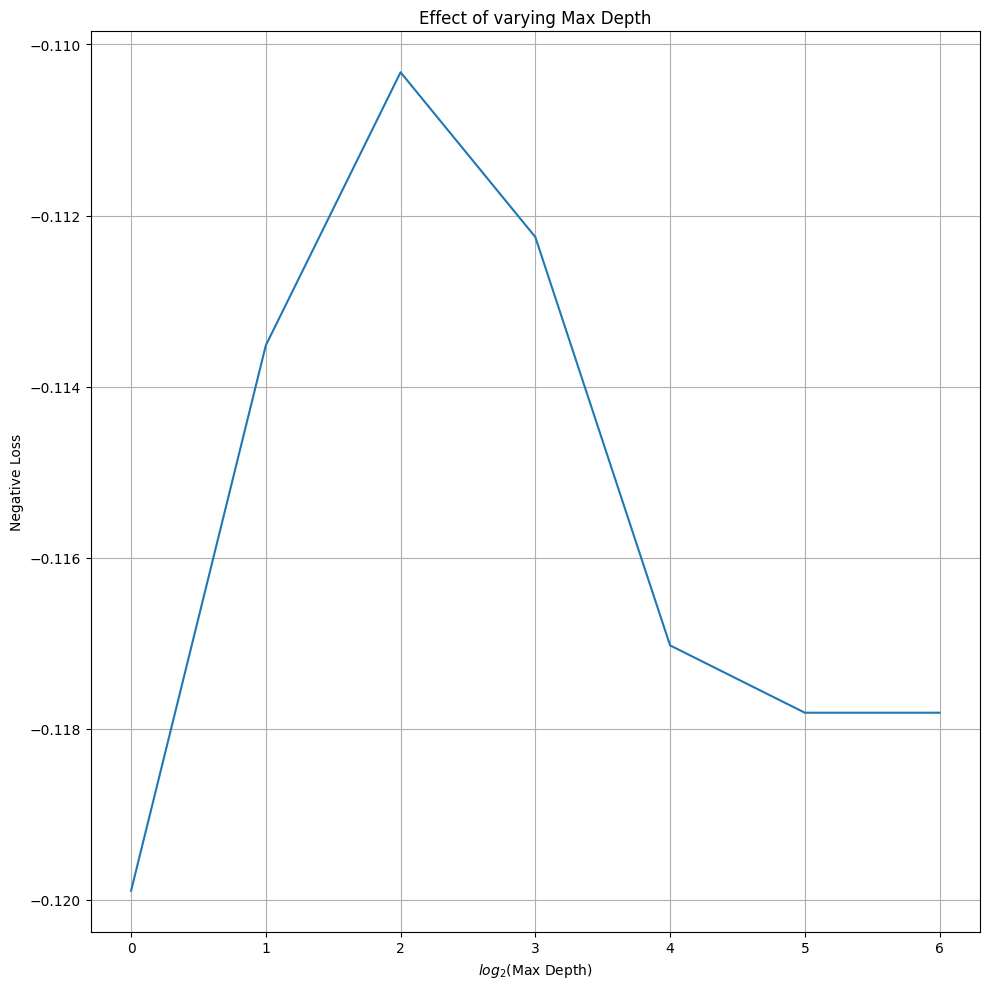

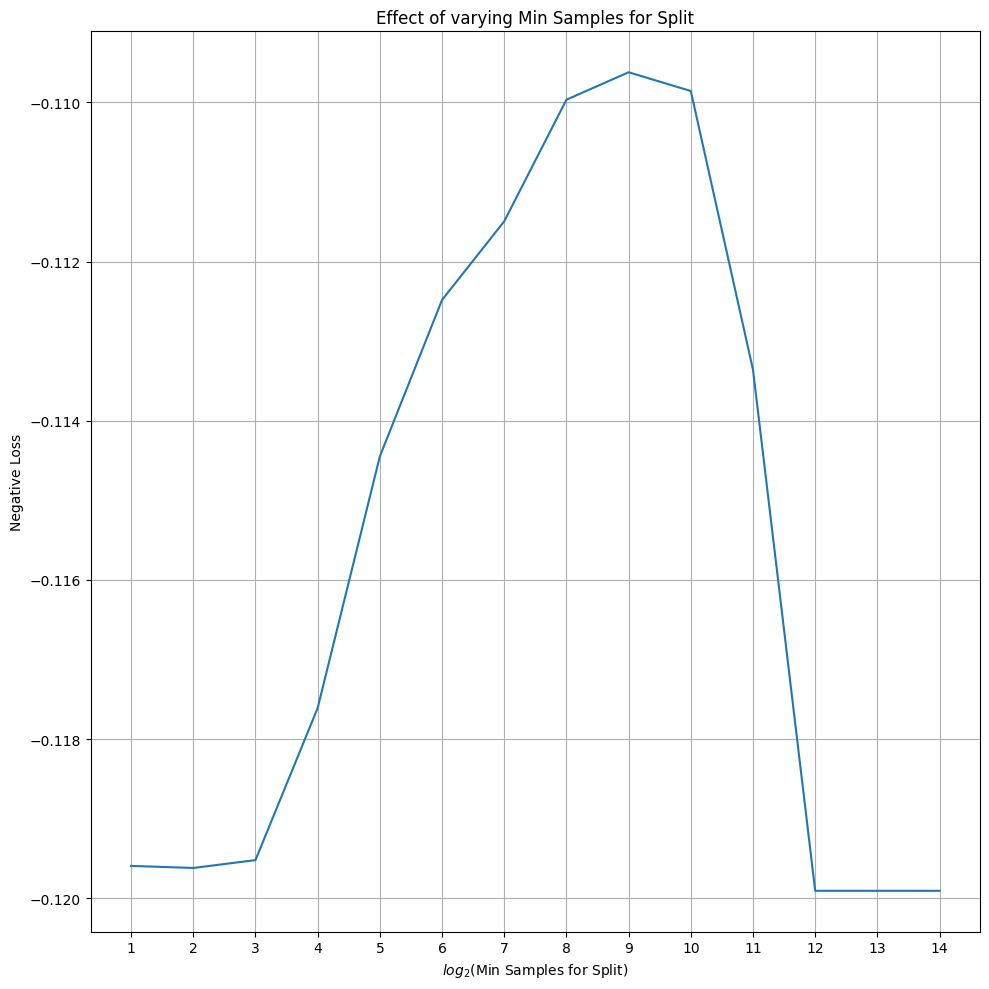

In [9]:
#Now to plot how the hyperparams change the model performance (on average)

#First to get lists of what params were used at each run
cv_max_depth = GS.cv_results_['param_max_depth']
cv_min_samples_split = GS.cv_results_['param_min_samples_split']

#And the score obtained at that run
performances = GS.cv_results_['mean_test_score']

#Group hyperparam data pre-evaluation
hyperparam_data = [
    (hp_list_max_depth, hp_list_max_depth_exponents, cv_max_depth, "Max Depth"), 
    (hp_list_min_samples_split, hp_list_min_samples_split_exponents, cv_min_samples_split, "Min Samples for Split")
]

evaluate(GS.best_params_, hyperparam_data, performances, "decision_tree_regressor", is_regression=True)

In [10]:
#Model 2 - Random Forest
from sklearn.ensemble import RandomForestRegressor

#Hyperparams - exponential grid-search
hp_list_n_estimators_exponents = [i for i in range(0,7)]
hp_list_n_estimators = [2**i for i in hp_list_n_estimators_exponents]

hp_list_max_depth_exponents = [i for i in range(0,4)]
hp_list_max_depth = [2**i for i in hp_list_max_depth_exponents]

hp_list_min_samples_split_exponents = [i for i in range(1, 4)]
hp_list_min_samples_split = [2**i for i in hp_list_min_samples_split_exponents]

parameters = {
    'n_estimators' : hp_list_n_estimators,
    'max_depth' : hp_list_max_depth,
    'min_samples_split' : hp_list_min_samples_split,
}

In [11]:
#Training (takes about 50 seconds)
RFR_model = RandomForestRegressor(random_state=0)
GS = GridSearchCV(RFR_model, parameters, scoring='neg_mean_absolute_percentage_error')
GS.fit(features_white.to_numpy(), target_white.to_numpy())

GridSearchCV(estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [1, 2, 4, 8],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [1, 2, 4, 8, 16, 32, 64]},
             scoring='neg_mean_absolute_percentage_error')

Best hyperparams overall:
{'max_depth': 8, 'min_samples_split': 8, 'n_estimators': 64}


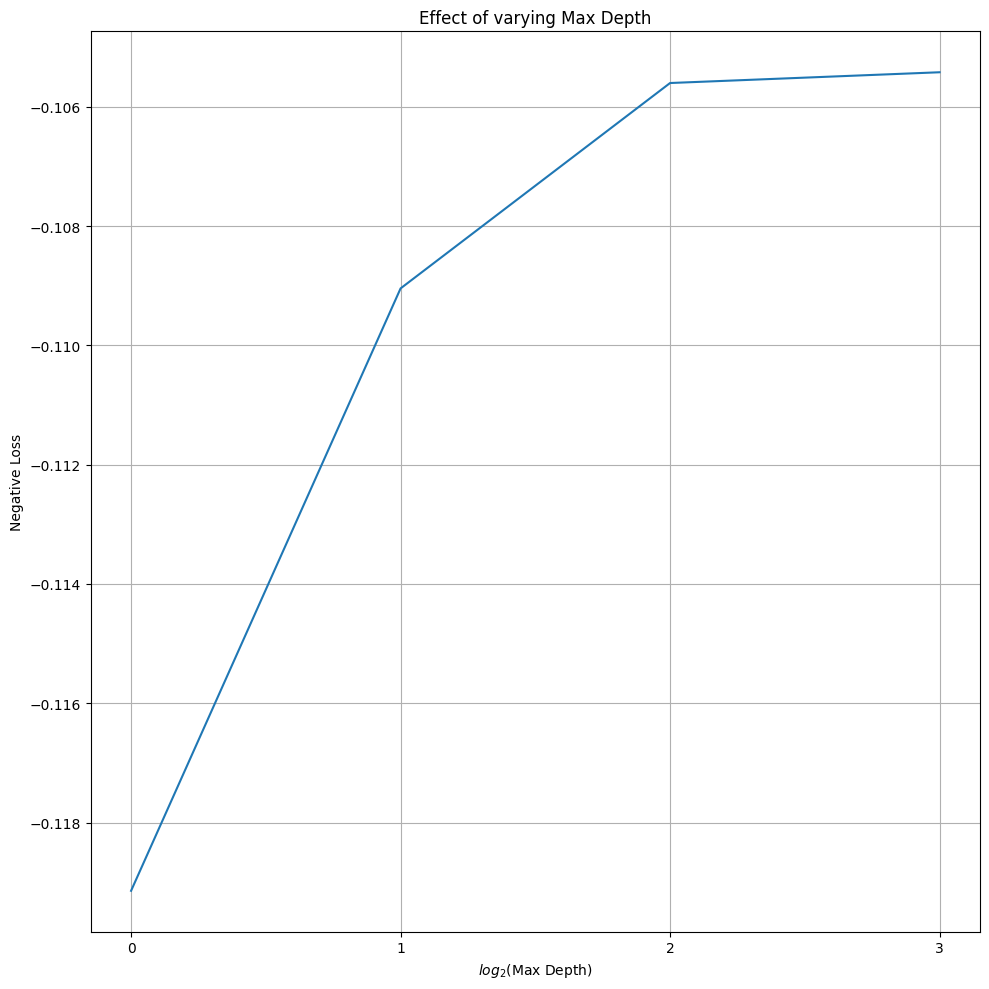

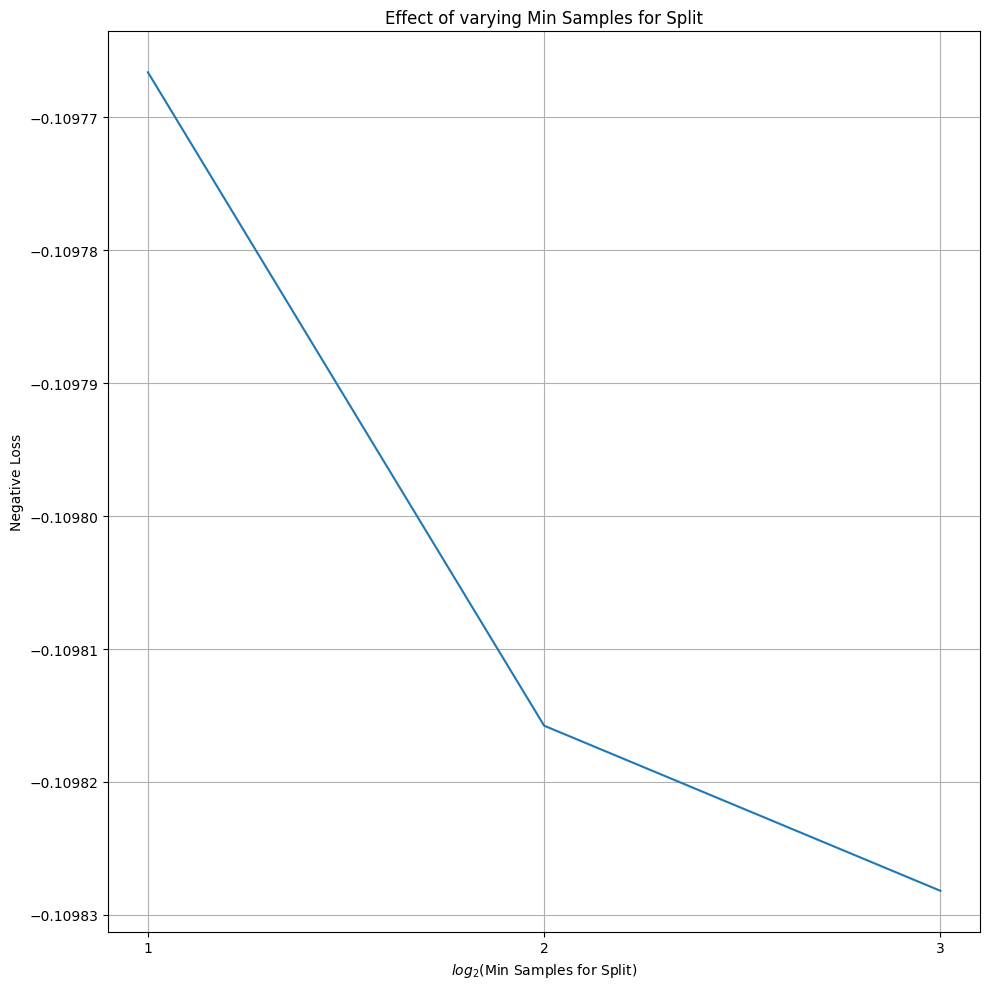

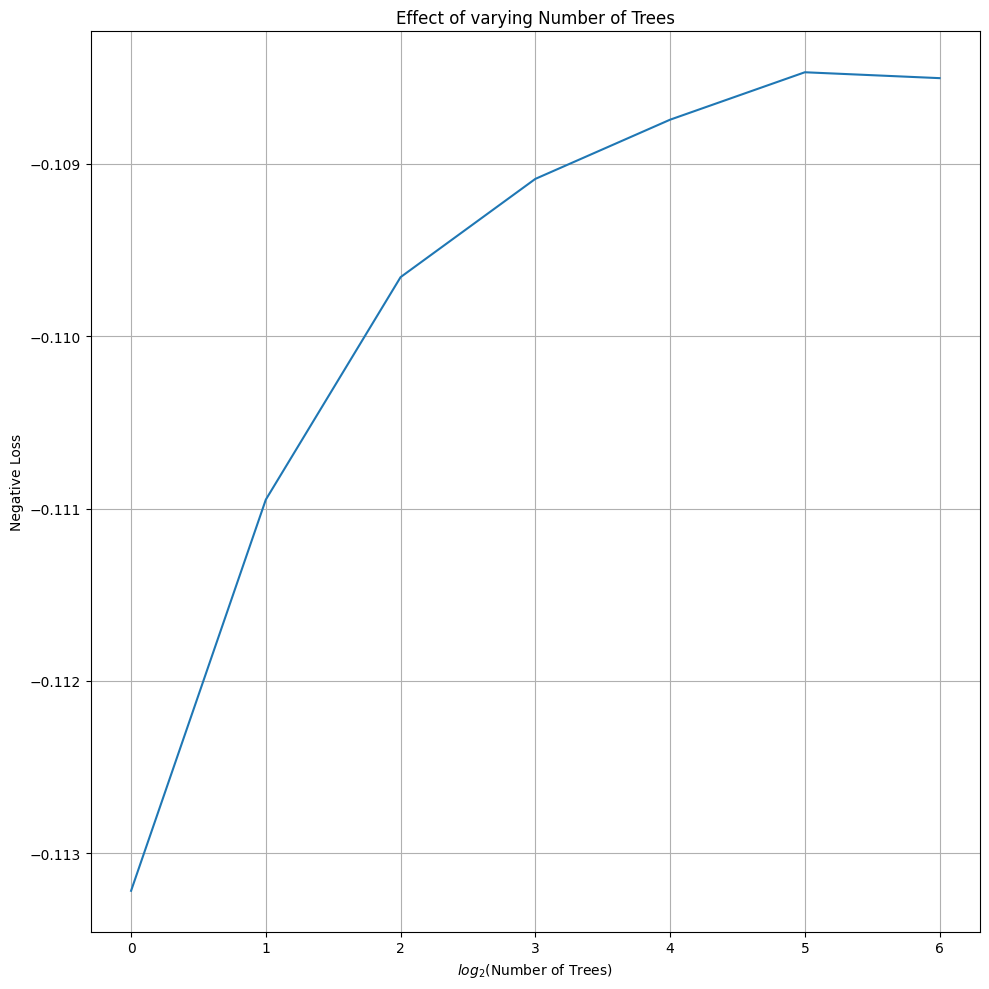

In [12]:
#Now to plot how the hyperparams change the model performance (on average)

#First to get lists of what params were used at each run
cv_n_estimators = GS.cv_results_['param_n_estimators']
cv_max_depth = GS.cv_results_['param_max_depth']
cv_min_samples_split = GS.cv_results_['param_min_samples_split']

#And the score obtained at that run
performances = GS.cv_results_['mean_test_score']

#Group hyperparam data pre-evaluation
hyperparam_data = [
    (hp_list_max_depth, hp_list_max_depth_exponents, cv_max_depth, "Max Depth"), 
    (hp_list_min_samples_split, hp_list_min_samples_split_exponents, cv_min_samples_split, "Min Samples for Split"),
    (hp_list_n_estimators, hp_list_n_estimators_exponents, cv_n_estimators, "Number of Trees"),
]

evaluate(GS.best_params_, hyperparam_data, performances, "random_forest_regressor", is_regression=True)

In [13]:
#Part 2 - HPO for classification

In [14]:
#Model 1 - Support Vector Classifier
from sklearn.svm import SVC

#Hyperparams - exponential grid-search, also some categorical choices for hyperparams
hp_list_C_exponents = [i for i in range(0,15)]
hp_list_C = [2**i for i in hp_list_C_exponents]

hp_list_kernel = ['poly', 'rbf']

parameters = {
    'C': hp_list_C,
    'kernel' : hp_list_kernel,
}

In [15]:
#Training (takes about 60 seconds)
SVC_model = SVC(random_state=0)
GS = GridSearchCV(SVC_model, parameters, scoring='accuracy')
GS.fit(features_all.to_numpy(), target_all.to_numpy())

GridSearchCV(estimator=SVC(random_state=0),
             param_grid={'C': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024,
                               2048, 4096, 8192, 16384],
                         'kernel': ['poly', 'rbf']},
             scoring='accuracy')

Best hyperparams overall:
{'C': 16384, 'kernel': 'rbf'}


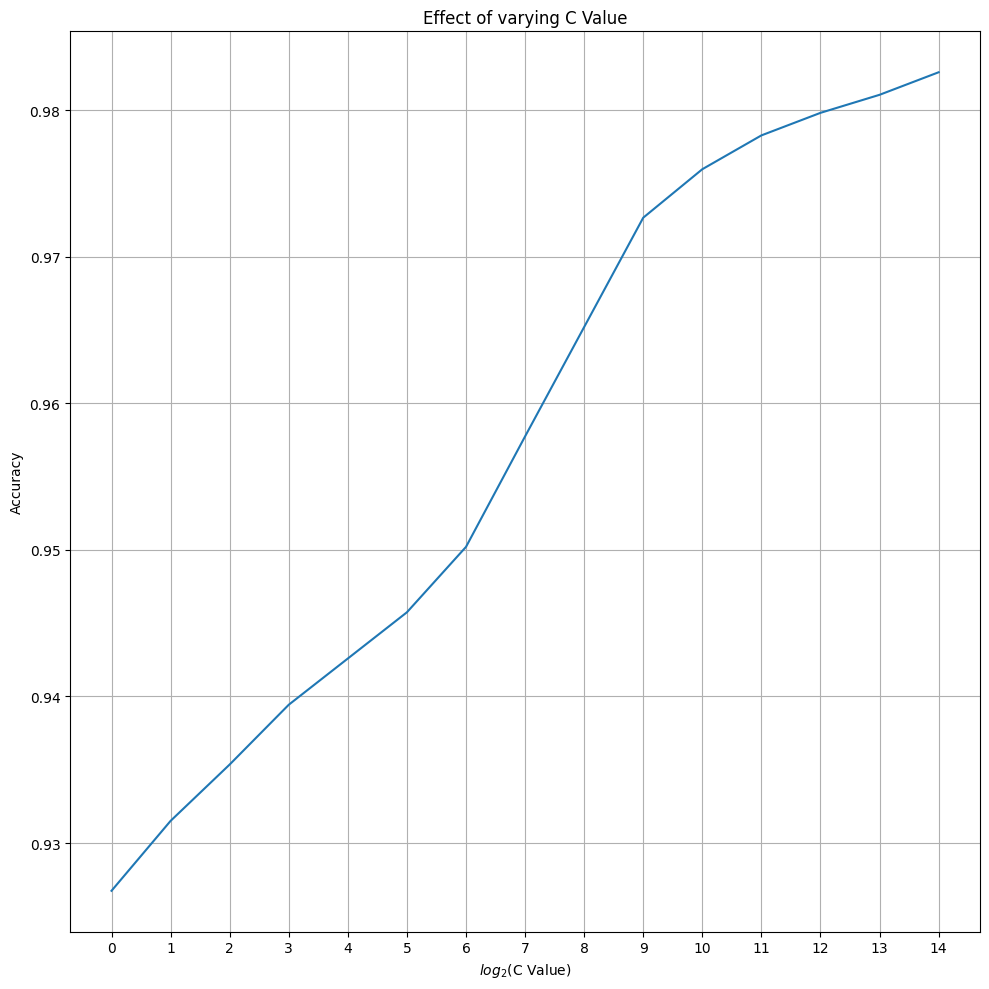

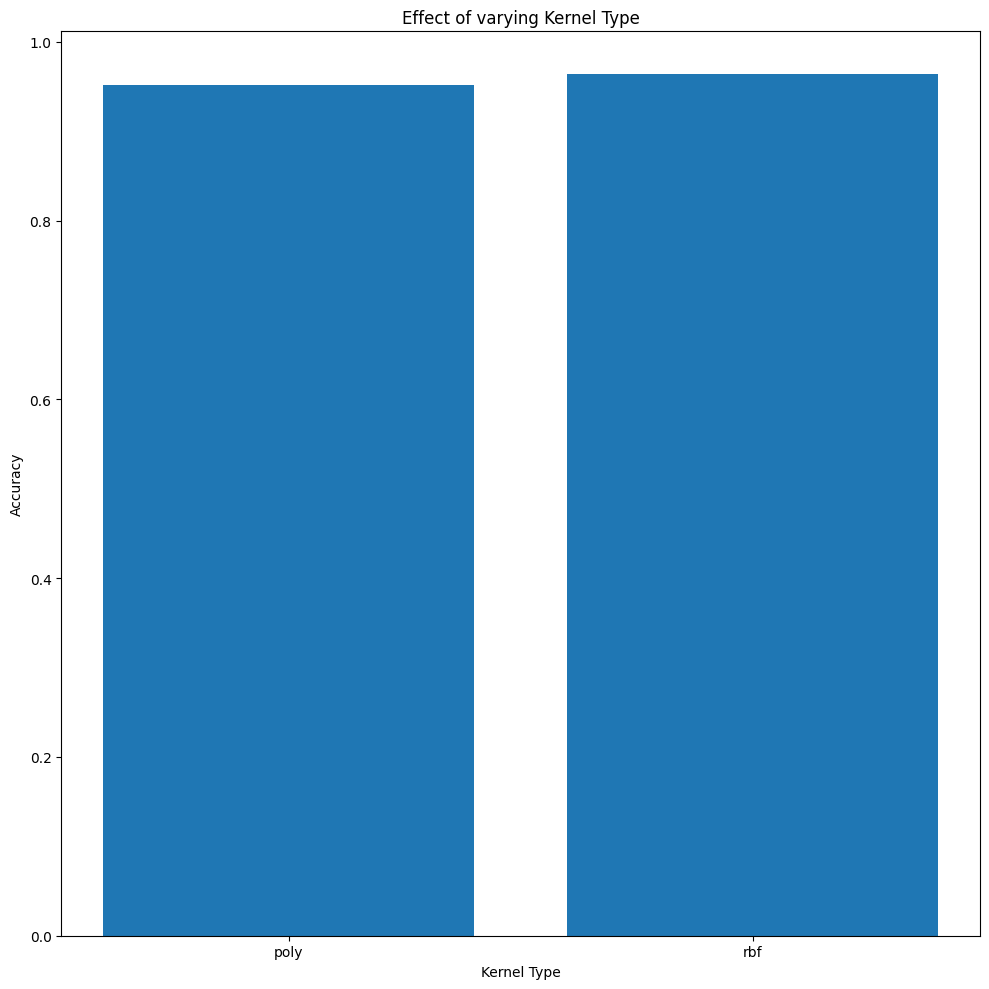

In [16]:
#Now to plot how the hyperparams change the model performance (on average)

#First to get lists of what params were used at each run
cv_C = GS.cv_results_['param_C']
cv_kernel = GS.cv_results_['param_kernel']

#And the score obtained at that run
performances = GS.cv_results_['mean_test_score']

#Group hyperparam data pre-evaluation
hyperparam_data = [
    (hp_list_C, hp_list_C_exponents, cv_C, "C Value"),
    (hp_list_kernel, None, cv_kernel, "Kernel Type"),
]

evaluate(GS.best_params_, hyperparam_data, performances, "SVC", is_regression=False)

In [17]:
#Model 2 - Logistic regression
from sklearn.linear_model import LogisticRegression

#Hyperparams - exponential grid-search, also some categorical choices for hyperparams
hp_list_C_exponents = [i for i in range(0,8)]
hp_list_C = [2**i for i in hp_list_C_exponents]

hp_list_penalty = ['l1', 'l2'] #Note that for these, not all solvers are compatible. liblinear is one that is compatible

parameters = {
    'C': hp_list_C,
    'penalty' : hp_list_penalty,
}

In [18]:
#Training (takes about 40 seconds)
log_reg_model = LogisticRegression(random_state=0, solver='liblinear')
GS = GridSearchCV(log_reg_model, parameters, scoring='accuracy')
GS.fit(features_all.to_numpy(), target_all.to_numpy())

GridSearchCV(estimator=LogisticRegression(random_state=0, solver='liblinear'),
             param_grid={'C': [1, 2, 4, 8, 16, 32, 64, 128],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

Best hyperparams overall:
{'C': 64, 'penalty': 'l2'}


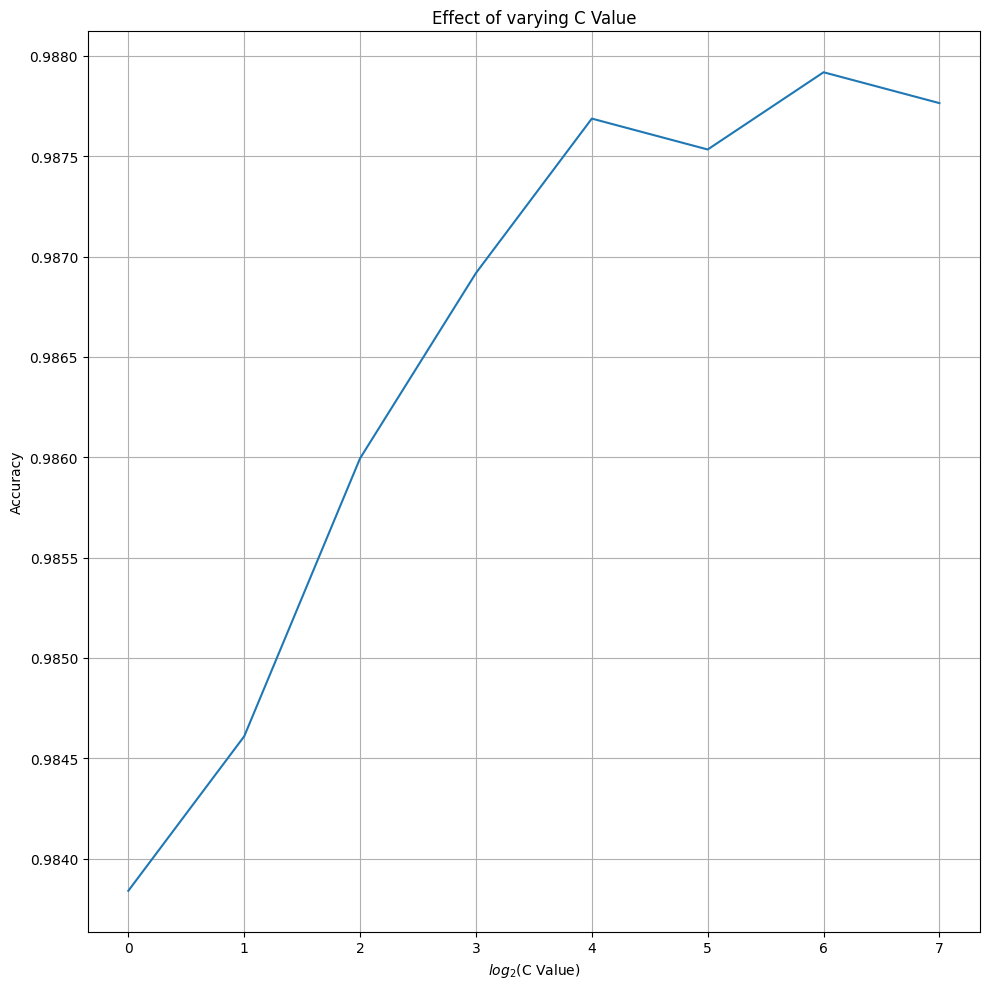

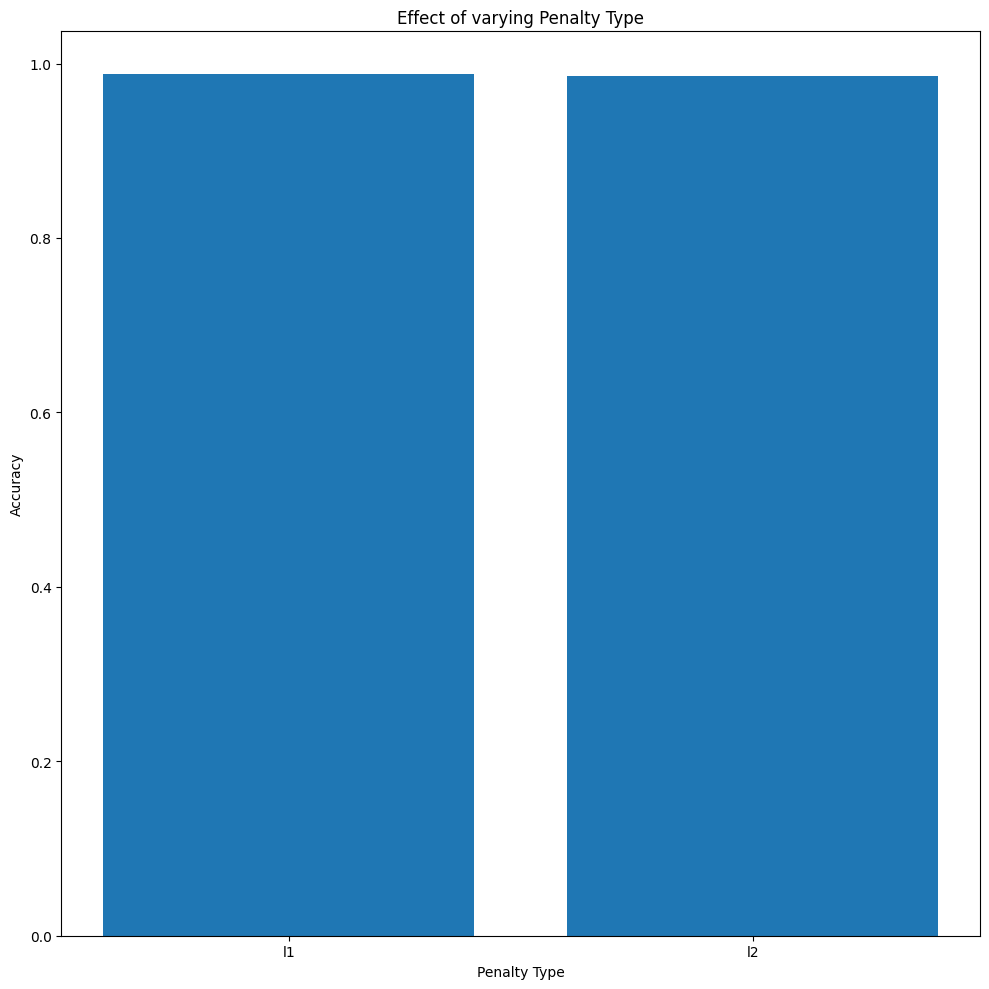

In [19]:
#Now to plot how the hyperparams change the model performance (on average)

#First to get lists of what params were used at each run
cv_C = GS.cv_results_['param_C']
cv_penalty = GS.cv_results_['param_penalty']

#And the score obtained at that run
performances = GS.cv_results_['mean_test_score']

#Group hyperparam data pre-evaluation
hyperparam_data = [
    (hp_list_C, hp_list_C_exponents, cv_C, "C Value"),
    (hp_list_penalty, None, cv_penalty, "Penalty Type"),
]

evaluate(GS.best_params_, hyperparam_data, performances, "logistic_regression", is_regression=False)

In [20]:
#Model 3 - Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier

#Hyperparams - exponential grid-search - similar to DecisionTreeRegressor from before
hp_list_max_depth_exponents = [i for i in range(0,7)]
hp_list_max_depth = [2**i for i in hp_list_max_depth_exponents]

hp_list_min_samples_split_exponents = [i for i in range(1, 15)]
hp_list_min_samples_split = [2**i for i in hp_list_min_samples_split_exponents]

parameters = {
    'max_depth' : hp_list_max_depth,
    'min_samples_split' : hp_list_min_samples_split,
}

In [21]:
#Training (takes about 8 seconds)
DTC = DecisionTreeClassifier(random_state=0)
GS = GridSearchCV(DTC, parameters, scoring='accuracy')
GS.fit(features_all.to_numpy(), target_all.to_numpy())

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [1, 2, 4, 8, 16, 32, 64],
                         'min_samples_split': [2, 4, 8, 16, 32, 64, 128, 256,
                                               512, 1024, 2048, 4096, 8192,
                                               16384]},
             scoring='accuracy')

Best hyperparams overall:
{'max_depth': 32, 'min_samples_split': 2}


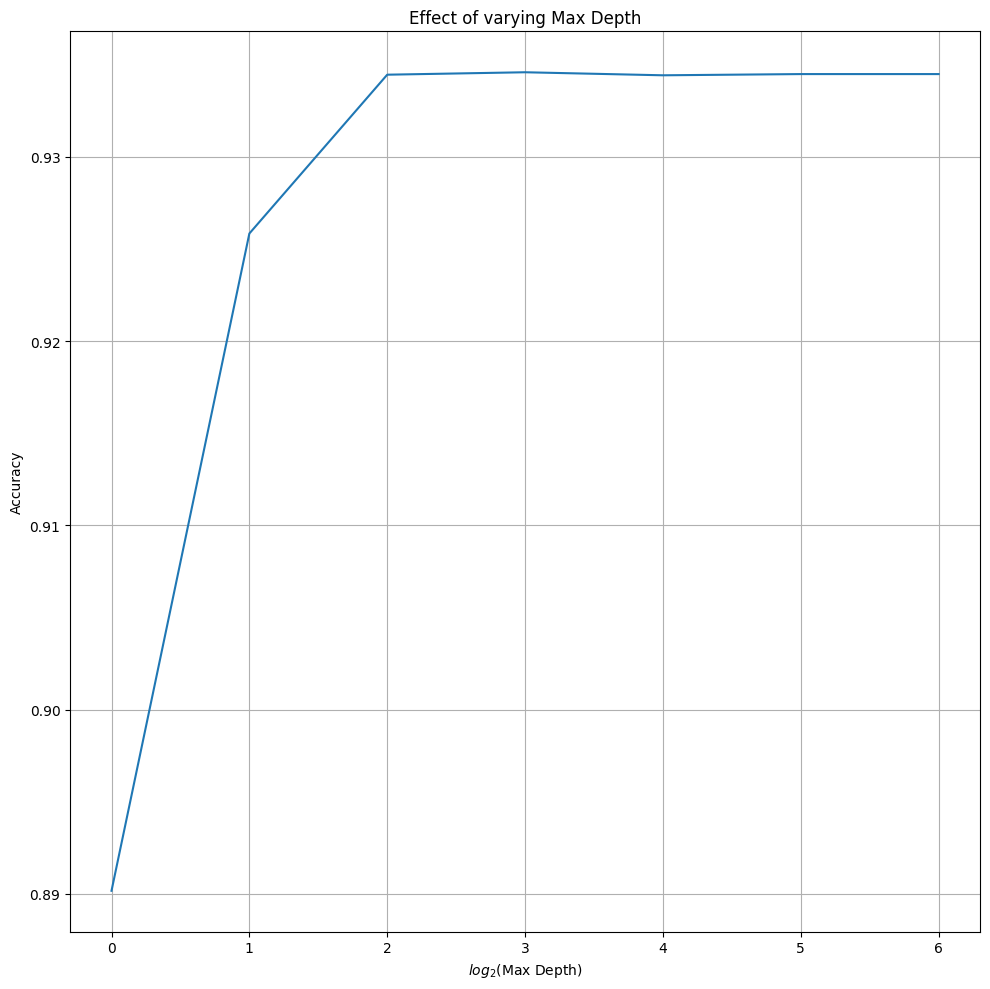

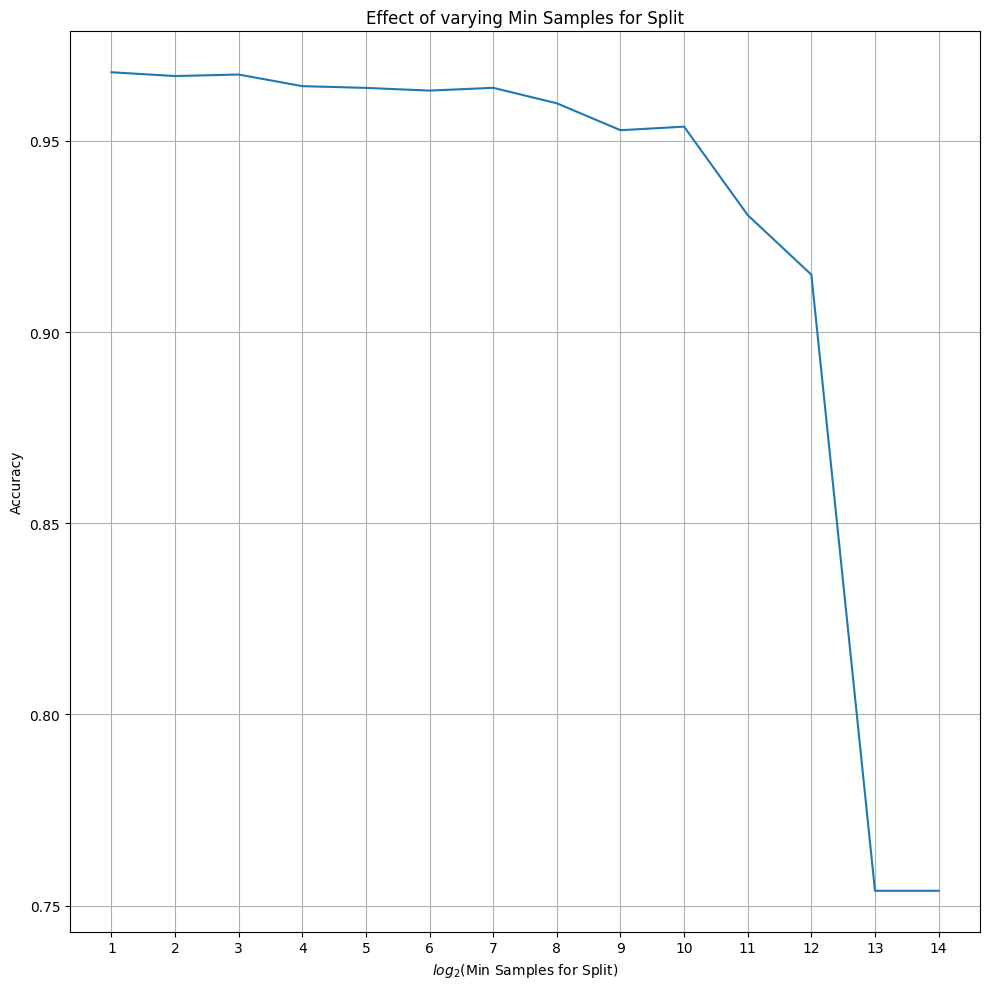

In [22]:
#Now to plot how the hyperparams change the model performance (on average)

#First to get lists of what params were used at each run
cv_max_depth = GS.cv_results_['param_max_depth']
cv_min_samples_split = GS.cv_results_['param_min_samples_split']

#And the score obtained at that run
performances = GS.cv_results_['mean_test_score']

#Group hyperparam data pre-evaluation
hyperparam_data = [
    (hp_list_max_depth, hp_list_max_depth_exponents, cv_max_depth, "Max Depth"),
    (hp_list_min_samples_split, hp_list_min_samples_split_exponents, cv_min_samples_split, "Min Samples for Split"),
]

evaluate(GS.best_params_, hyperparam_data, performances, "decision_tree_classifier", is_regression=False)

In [23]:
#Model 4 - K-nearest neighbor
from sklearn.neighbors import KNeighborsClassifier

#Hyperparams - exponential grid-search
hp_list_n_neighbors_exponents = [i for i in range(0,7)]
hp_list_n_neighbors = [2**i for i in hp_list_n_neighbors_exponents]

hp_list_metric = ['l1', 'l2']

parameters = {
    'n_neighbors' : hp_list_n_neighbors,
    'metric' : hp_list_metric,
}

In [24]:
#Training (takes about 2 seconds)
KNN = KNeighborsClassifier()
GS = GridSearchCV(KNN, parameters, scoring='accuracy')
GS.fit(features_all.to_numpy(), target_all.to_numpy())

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['l1', 'l2'],
                         'n_neighbors': [1, 2, 4, 8, 16, 32, 64]},
             scoring='accuracy')

Best hyperparams overall:
{'metric': 'l1', 'n_neighbors': 8}


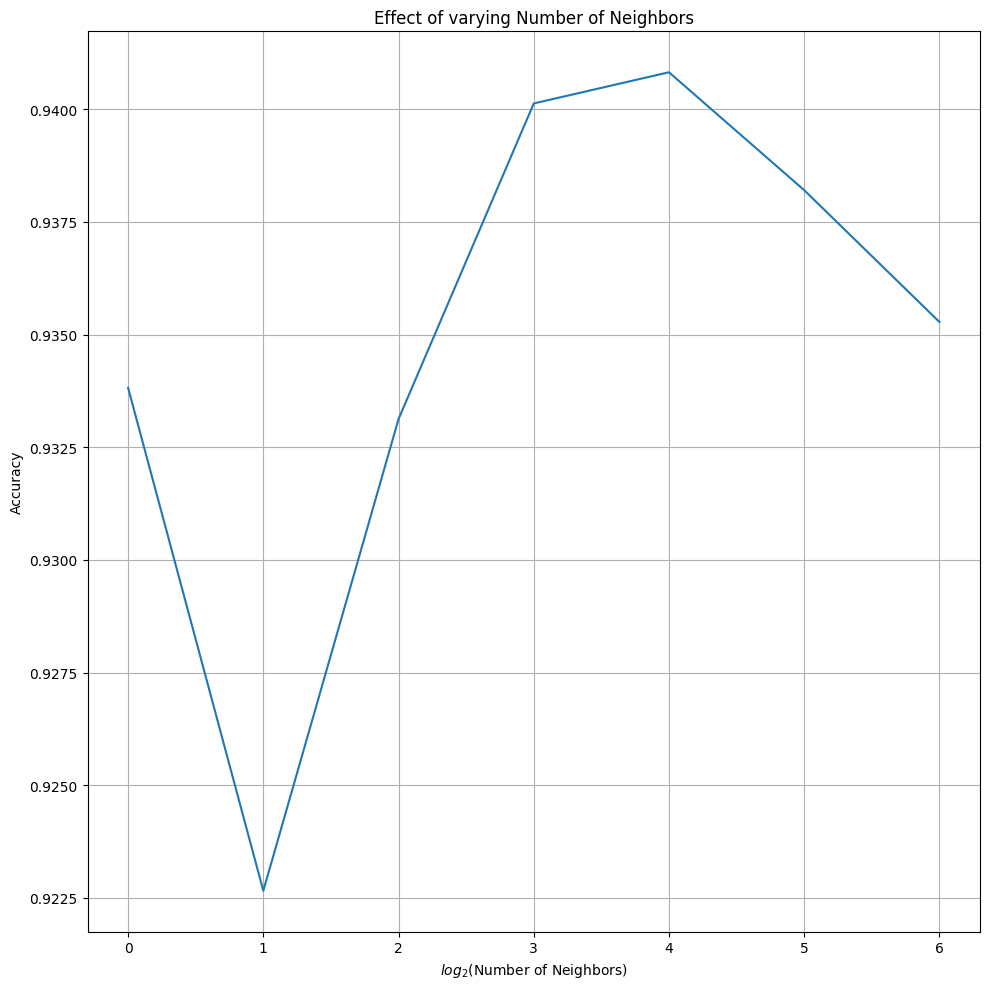

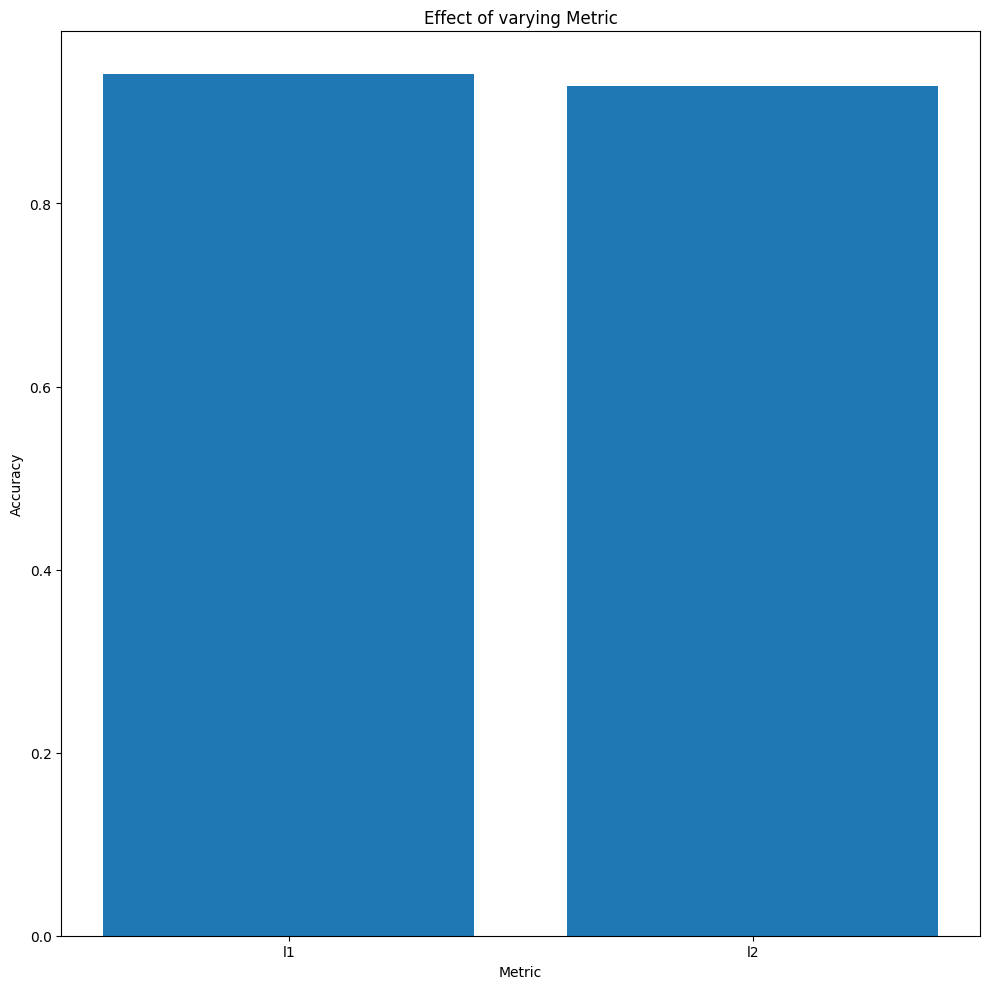

In [25]:
#Now to plot how the hyperparams change the model performance (on average)

#First to get lists of what params were used at each run
cv_n_neighbors = GS.cv_results_['param_n_neighbors']
cv_metric = GS.cv_results_['param_metric']

#And the score obtained at that run
performances = GS.cv_results_['mean_test_score']

#Group hyperparam data pre-evaluation
hyperparam_data = [
    (hp_list_n_neighbors, hp_list_n_neighbors_exponents, cv_n_neighbors, "Number of Neighbors"),
    (hp_list_metric, None, cv_metric, "Metric"),
]

evaluate(GS.best_params_, hyperparam_data, performances, "KNN", is_regression=False)

In [26]:
#Naive Bayes is often considered to have no hyperparams so it will be skipped

In [27]:
#Model 5 - Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

#Hyperparams - exponential grid-search - similar to the RandomForestRegressor from before
hp_list_n_estimators_exponents = [i for i in range(0,7)]
hp_list_n_estimators = [2**i for i in hp_list_n_estimators_exponents]

hp_list_max_depth_exponents = [i for i in range(0,4)]
hp_list_max_depth = [2**i for i in hp_list_max_depth_exponents]

hp_list_min_samples_split_exponents = [i for i in range(1, 4)]
hp_list_min_samples_split = [2**i for i in hp_list_min_samples_split_exponents]

parameters = {
    'n_estimators' : hp_list_n_estimators,
    'max_depth' : hp_list_max_depth,
    'min_samples_split' : hp_list_min_samples_split,
}

In [28]:
#Training (takes about 50 seconds)
RFC_model = RandomForestClassifier(random_state=0)
GS = GridSearchCV(RFC_model, parameters, scoring='accuracy')
GS.fit(features_all.to_numpy(), target_all.to_numpy())

GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [1, 2, 4, 8],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [1, 2, 4, 8, 16, 32, 64]},
             scoring='accuracy')

Best hyperparams overall:
{'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 32}


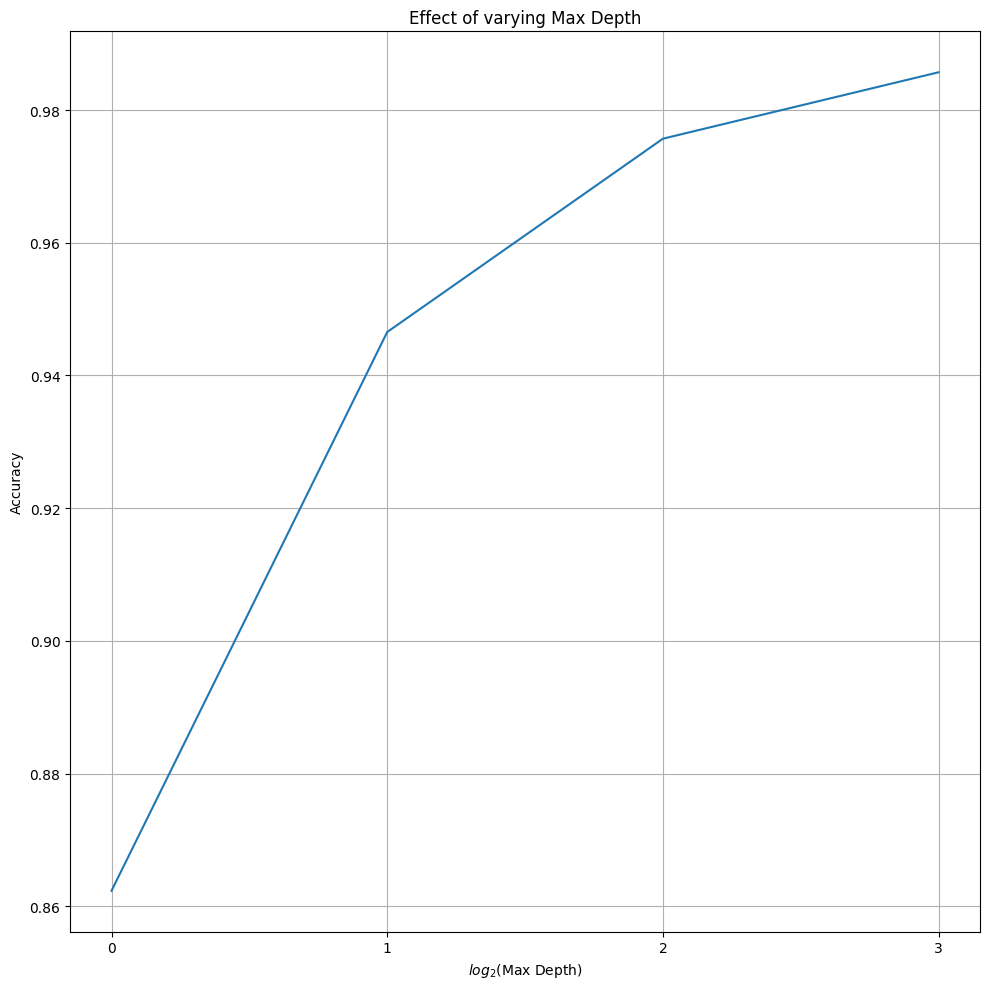

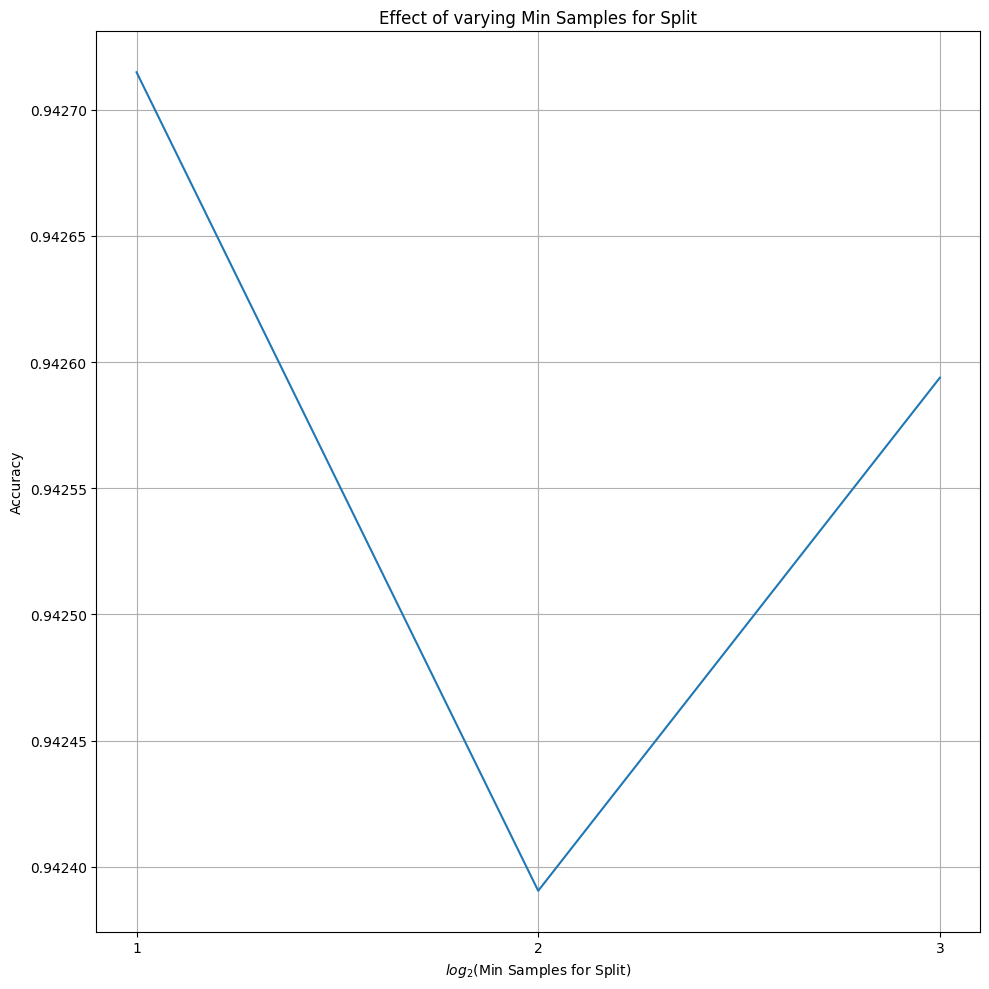

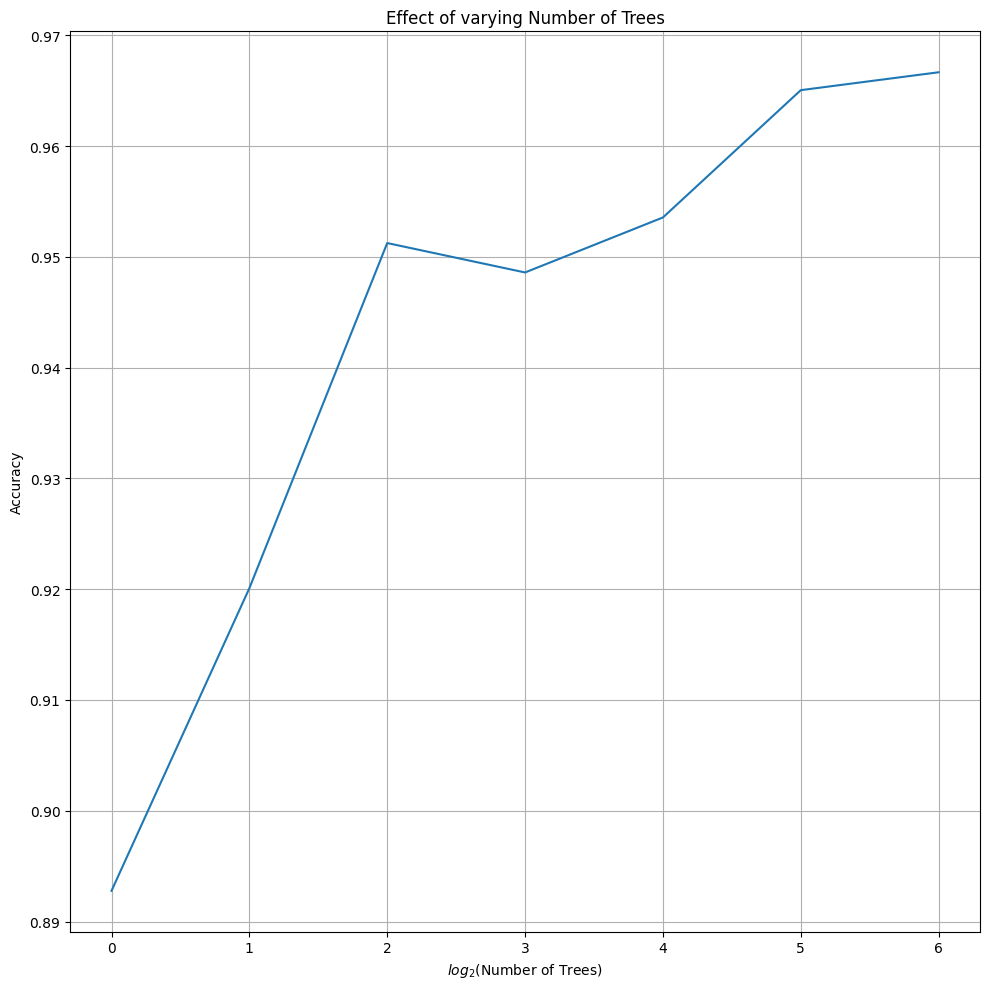

In [29]:
#Now to plot how the hyperparams change the model performance (on average)

#First to get lists of what params were used at each run
cv_n_estimators = GS.cv_results_['param_n_estimators']
cv_max_depth = GS.cv_results_['param_max_depth']
cv_min_samples_split = GS.cv_results_['param_min_samples_split']

#And the score obtained at that run
performances = GS.cv_results_['mean_test_score']

#Group hyperparam data pre-evaluation
hyperparam_data = [
    (hp_list_max_depth, hp_list_max_depth_exponents, cv_max_depth, "Max Depth"), 
    (hp_list_min_samples_split, hp_list_min_samples_split_exponents, cv_min_samples_split, "Min Samples for Split"),
    (hp_list_n_estimators, hp_list_n_estimators_exponents, cv_n_estimators, "Number of Trees"),
]

evaluate(GS.best_params_, hyperparam_data, performances, "random_forest_classifier", is_regression=False)